In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
import scipy
from scipy.stats import norm
from scipy.spatial import distance
from scipy.spatial.distance import euclidean as euclidean
import torch
import torch.nn.functional as F
from torch import optim
import torch.nn as nn
import seaborn as sns

In [2]:
def split(dataset, labelCol):
    
    training = []
    validation = []
    
    dataset = dataset[dataset[:,labelCol].argsort()]
    
    for i in range(len(dataset)):
        
        if i % 10 == 0:
            validation.append(dataset[i])
        
        else:
            training.append(dataset[i])
    
    return np.asarray(training), np.asarray(validation)

In [3]:
#2D Potential

x1 = 0.5
y1 = 0.5

x2 = -0.8
y2 = 0

W = 0.0001
sigma = 0.4

factor = 2

def gaussian(x, xo):
    
    g = math.exp(-1 * math.pow((x - xo), 2)/(2 * math.pow(sigma,2)))
    
    return g

def twoDpotential(x,y):
    
    V = W * (math.pow(x,6) + math.pow(y,6)) - factor * (gaussian(x, x1) * gaussian(y, y1)) \
        - factor * (gaussian(x, x2) * gaussian(y, y2)) 
    
    return V

def accX(x,y,vX):
    
    acc = W * (6 * math.pow(x,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (x - x1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (x - x2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def accY(x,y,vY):
    
    acc = W * (6 * math.pow(y,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (y - y1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (y - y2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def run_2D_md(dt, number_of_steps, temp, coord):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
#    positions = np.zeros((number_of_steps, len(x)))
    positionsX = []
    positionsY = []
    positionsX.append(coord[0])
    positionsY.append(coord[1])
    
    x = coord[0]
    y = coord[1]
    
    vX = np.random.uniform(-1 * temp, temp)
    vY = np.random.uniform(-1 * temp, temp)
    aX = accX(x,y,vX)
    aY = accY(x,y,vY)

    for i in range(number_of_steps):
        x = update_pos(x, vX, aX, dt)
        y = update_pos(y, vY, aY, dt)
        a1X = accX(x,y,vX)
        a1Y = accY(x,y,vY)
        vX = update_velo(vX, aX, a1X, dt)
        vY = update_velo(vY, aY, a1Y, dt)
        aX = np.array(a1X)
        aY = np.array(a1Y)
        positionsX.append(x)
        positionsY.append(y)
#        print(x,y,vX,vY,aX,aY,i)
#        positions[i, :] = x
    return positionsX, positionsY

In [4]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=5, **kwargs ):
    x = initial_position[0]
    y = initial_position[1]
    vx = initial_velocity[0]
    vy = initial_velocity[1]

    t = 0
    step_number = 0
    
    positions = []
    velocities = []
    
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy = potential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceY = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)
        
        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)

        #O
        vx = random_velocity_update(vx,gamma,kBT,dt)
        vy = random_velocity_update(vy,gamma,kBT,dt)

        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)
        
        # B
        potential_energy = twoDpotential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceX = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)

        if step_number%save_frequency == 0 and step_number>0:
            ke = .5*(vx*vx + vy*vy)
            pe = potential_energy

            positions.append([x,y])
            velocities.append([vx,vy])
            total_energies.append([ke,pe,ke+pe])
            save_times.append(t)
        
        if t % (500) < 0.01:
            print("Currently at t = " + str(t))
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

Initial Coordinates = 0.1, 0.1
Initial Velocities = 0.14886219170227538, -0.033931774700409895
Initial Kinetic Energy = 0.01165565872636218
Initial Potential energy = -0.8899823220795181
Initial Total energy = -0.8783266633531559
Currently at t = 0
Currently at t = 500.00999999969025
Currently at t = 1000.0099999992356
Currently at t = 1500.0099999987808
Currently at t = 2000.009999998326
Currently at t = 2500.0000000081486
Currently at t = 3000.0000000190626
Currently at t = 3500.0000000299765
Currently at t = 4000.0000000408904
Currently at t = 4500.000000051804
Currently at t = 5000.000000062718
Currently at t = 5500.000000073632
Currently at t = 6000.000000084546
Currently at t = 6500.00000009546
Currently at t = 7000.000000106374
Currently at t = 7500.0000001172875
Currently at t = 8000.0000001282015
Currently at t = 8500.000000139114
Currently at t = 9000.000000150028
Currently at t = 9500.000000160942


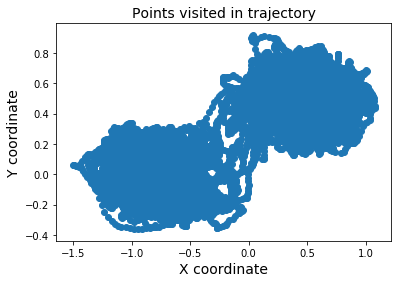

In [52]:
my_max_time = 10000

x = 0.1
y = 0.1
vx = np.random.normal(0,0.3)
vy = np.random.normal(0,0.3)

initial_position = [x,y]
initial_velocity = [vx,vy]

my_gamma = 5
my_kBT=(1/12.5)
my_dt=0.01

KE = 0.5 * (vx * vx + vy * vy)
PE = twoDpotential(x,y)

print("Initial Coordinates = " + str(x) + ", " + str(y))
print("Initial Velocities = " + str(vx) + ", " + str(vy))
print("Initial Kinetic Energy = " + str(KE))

print("Initial Potential energy = " + str(PE))

print("Initial Total energy = " + str(PE + KE))


times, positions, velocities, total_energies = baoab(twoDpotential, \
                                                    my_max_time, my_dt, my_gamma, my_kBT, \
                                                    initial_position, initial_velocity,\
                                                    )



times = np.asarray(times)
positions = np.asarray(positions)
velocities = np.asarray(velocities)
total_energies = np.asarray(total_energies)


plt.title('Points visited in trajectory', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(positions[:,0], positions[:,1])
plt.savefig('toyModel/2DlangevinAsymmetric/trajectory.png')

In [53]:
print("Average Kinetic Energy = " + str(total_energies[:,0].mean()))
print("kBT = ", my_kBT)
print("Average Potential Energy = " + str(total_energies[:,1].mean()))
print("Average Total Energy = " + str(total_energies[:,2].mean()))

Average Kinetic Energy = 0.08314730183129194
kBT =  0.08
Average Potential Energy = -1.8507728020480747
Average Total Energy = -1.7676255002167827


In [54]:
# np.save('toyModel/2DlangevinAsymmetric/positions.npy', positions)
# np.save('toyModel/2DlangevinAsymmetric/velocities.npy', velocities)w

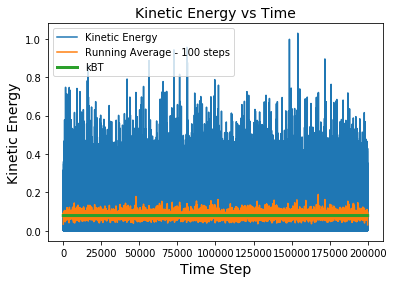

In [55]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

window_size = 100
ke_av = movingaverage(total_energies[:,0], window_size)

plt.title('Kinetic Energy vs Time', size=14)
plt.plot(total_energies[:,0], label = 'Kinetic Energy')
plt.plot(ke_av, label='Running Average - ' + str(window_size) + ' steps')
plt.plot([my_kBT]*len(total_energies[:,0]), linewidth=3.0, label='kBT')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Kinetic Energy', size=14)
plt.savefig('toyModel/2DlangevinAsymmetric/KE.png')


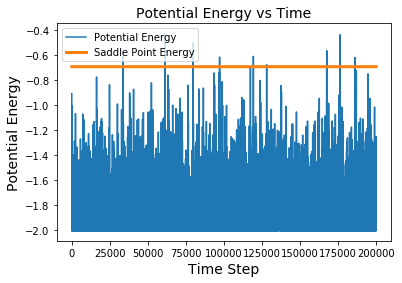

In [56]:
plt.title('Potential Energy vs Time', size=14)
plt.plot(total_energies[:,1], label = 'Potential Energy')
plt.plot([twoDpotential(0,0)]*len(total_energies[:,0]), linewidth=3.0, label='Saddle Point Energy')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Potential Energy', size=14)
plt.savefig('toyModel/2DlangevinAsymmetric/PE.png')


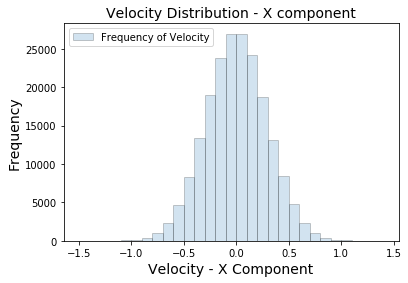

In [57]:
plt.title('Velocity Distribution - X component', size=14)
plt.xlabel('Velocity - X Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,0], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinAsymmetric/velocityX.png')

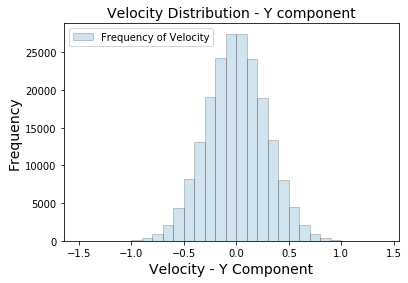

In [58]:
plt.title('Velocity Distribution - Y component', size=14)
plt.xlabel('Velocity - Y Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,1], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinAsymmetric/velocityY.png')

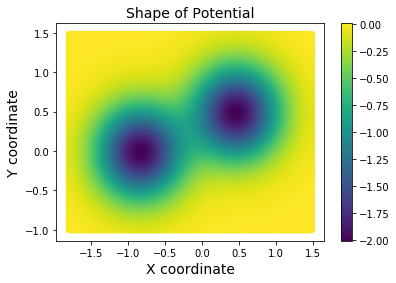

In [59]:
a = np.arange(x2-1,x1+1,0.02)
b = np.arange(y2-1,y1+1,0.02)

potential = []

for x in a:
    for y in b:
        
        potential.append([x,y,twoDpotential(x,y)])

potential = np.asarray(potential)

plt.title('Shape of Potential', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(potential[:,0],potential[:,1],c=potential[:,2])
# plt.tricontour(potential[:,0],potential[:,1],potential[:,2],500)
plt.colorbar()
plt.savefig('toyModel/2DlangevinAsymmetric/potential.png')

In [60]:
positionsX = positions[:,0]
positionsY = positions[:,1]
velocitiesX = velocities[:,0]
velocitiesY = velocities[:,1]

min1 = twoDpotential(x1,y1)
min2 = twoDpotential(x2,y2)

width = my_kBT

data = np.vstack((positionsX,positionsY,velocitiesX,velocitiesY)).T

dataset = []
nextState = [-1, -1]

nTransitions = -1
prevState = -1

tTransitions = []

cutoff = 10000000000

inBasin= [-1, -1]

indet = [-1, -1]

for i in range(len(data)):
    
    if i % 9999 == 0:
        print("Finished step: " + str(i+1) + " of " + str(len(data)))
    
    x = data[i][0]
    y = data[i][1]
    velX = data[i][2]
    velY = data[i][3]
    
    if i < nextState[0]:
        dataset.append([x, y, velX, velY, nextState[1]])
        continue
    
    if indet[0] == 1:
        
        xj = data[indet[1] + 1][0]
        yj = data[indet[1] + 1][1]
        
        currPotential = twoDpotential(xj,yj)
        
        dist1 = distance.euclidean([xj,yj],[x1,y1])
        dist2 = distance.euclidean([xj,yj],[x2,y2])

        
        if currPotential - min1 < width and dist1 < dist2:
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 1
                nTransitions += 1

            else:
                if prevState != 1:
                    nTransitions += 1
                    prevState = 1
                    tTransitions.append(i)
            
            continue

        elif currPotential - min2 < width and dist2 < dist1:
            dataset.append([x, y, velX, velY, 2])
            nextState = [j,2]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 2
                nTransitions += 1
                
            else:
                if prevState != 2:
                    nTransitions += 1
                    prevState = 2
                    tTransitions.append(i)
            
            continue
        
        else:
            dataset.append([x, y, velX, velY, 3])
            indet = [1,indet[1]+1]
            continue

    currPotential = twoDpotential(x,y)

    dist1 = distance.euclidean([x,y],[x1,y1])
    dist2 = distance.euclidean([x,y],[x2,y2])
    
    if 0 <= currPotential - min1 <= width and dist1 < dist2:
        dataset.append([x, y, velX, velY, 1])
        inBasin = i
        continue
    
    if 0 <= currPotential - min2 <= width and dist2 < dist1:
        dataset.append([x, y, velX, velY, 2])
        inBasin = i
        continue
    
    for j in range(i, len(data)):
        
        if j - i > cutoff:
            dataset.append([x,y, velX, velY, 3])
            indet = [1, j]
            break
            
        xj = data[j][0]
        yj = data[j][1]
        
        dist1 = distance.euclidean([xj,yj],[x1,y1])
        dist2 = distance.euclidean([xj,yj],[x2,y2])
        
        currPotential = twoDpotential(xj,yj)
        
        if 0 <= currPotential - min1 <= width and dist1 < dist2:
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            indet = [-1, -1]
            
            if nTransitions == -1:
                prevState = 1
                nTransitions += 1

            else:
                if prevState != 1:
                    nTransitions += 1
                    prevState = 1
                    tTransitions.append(np.asarray([inBasin,j]))
            break

        if 0 <= currPotential - min2 <= width and dist2 < dist1:
            
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,2]
            indet = [-1,-1]
            
            if nTransitions == -1:
                prevState = 2
                nTransitions += 1
                
            else:
                if prevState != 2:
                    nTransitions += 1
                    prevState = 2
                    tTransitions.append(np.asarray([inBasin,j]))
            break

dataset = np.asarray(dataset)
unique, counts = np.unique(dataset[:,4], return_counts = True)
print(unique, counts)

Finished step: 1 of 199999
Finished step: 10000 of 199999
Finished step: 19999 of 199999
Finished step: 29998 of 199999
Finished step: 39997 of 199999
Finished step: 49996 of 199999
Finished step: 59995 of 199999
Finished step: 69994 of 199999
Finished step: 79993 of 199999
Finished step: 89992 of 199999
Finished step: 99991 of 199999
Finished step: 109990 of 199999
Finished step: 119989 of 199999
Finished step: 129988 of 199999
Finished step: 139987 of 199999
Finished step: 149986 of 199999
Finished step: 159985 of 199999
Finished step: 169984 of 199999
Finished step: 179983 of 199999
Finished step: 189982 of 199999
Finished step: 199981 of 199999
[1. 2.] [112937  86992]


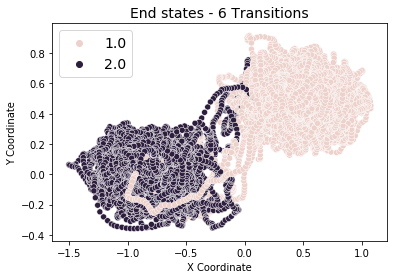

In [61]:
import seaborn as sns

text = 'nTransitions = ' + str(nTransitions)
df = pd.DataFrame(dataset, columns = ['X Coordinate','Y Coordinate','velX','velY','endState'])
a = sns.scatterplot(data=df, x='X Coordinate', y='Y Coordinate', hue='endState')
a.legend(fontsize=14)
a.set_title('End states - ' + str(nTransitions) + ' Transitions', size=14)
a.figure.savefig('toyModel/2DlangevinAsymmetric/endState.png')

In [64]:
import torch 
import torch.nn.functional as F
from torch import optim
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8)
        self.hidden2 = nn.Linear(8,4)
        self.activation = nn.ReLU()
        self.output = nn.Linear(4, 2)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [65]:
dataset = np.asarray(dataset)

labelCol = len(dataset[0]) - 1
training, validation = split(dataset, labelCol)

trainInputs = training[:,:labelCol]
trainLabels = training[:,labelCol]
validInputs = validation[:,:labelCol]
validLabels = validation[:,labelCol]

trainInputs = torch.Tensor(trainInputs)
trainLabels = torch.Tensor(trainLabels).type(torch.LongTensor) - 1

In [67]:
model = Model()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
nEpochs = 1000
losses = np.zeros(nEpochs)

for epoch in range(0, nEpochs): ## run the model for 100 epochs
    
    model.train()
    
    optimizer.zero_grad()
    
    output = model(trainInputs)
    loss = loss_function(output, trainLabels)
    
    loss.backward()
    
    optimizer.step()
    
    losses[epoch] = np.mean(loss.item())
    
    if epoch % 100 == 0:
        print ("Epoch:", epoch, "Training Loss: ", np.mean(loss.item()), ((output.argmax(dim=1) == trainLabels).sum()/len(trainLabels)).item())

Epoch: 0 Training Loss:  0.698158323764801 0.4352714419364929
Epoch: 100 Training Loss:  0.29668766260147095 0.9839553833007812
Epoch: 200 Training Loss:  0.09364180266857147 0.9841554760932922
Epoch: 300 Training Loss:  0.07700984179973602 0.9841499328613281
Epoch: 400 Training Loss:  0.07292062789201736 0.9841832518577576
Epoch: 500 Training Loss:  0.07020112872123718 0.9839998483657837
Epoch: 600 Training Loss:  0.06852256506681442 0.9839887619018555
Epoch: 700 Training Loss:  0.06750565022230148 0.9840109944343567
Epoch: 800 Training Loss:  0.06684886664152145 0.9840610027313232
Epoch: 900 Training Loss:  0.06628989428281784 0.9840720891952515


In [28]:
# from sklearn.neural_network import MLPClassifier
# from sklearn import preprocessing

# dataset = np.asarray(dataset)

# labelCol = len(dataset[0]) - 1
# training, validation = split(dataset, labelCol)

# trainInputs = training[:,:labelCol]
# trainLabels = training[:,labelCol]
# validInputs = validation[:,:labelCol]
# validLabels = validation[:,labelCol]

# scaler = preprocessing.StandardScaler().fit(trainInputs)

# clf = MLPClassifier(hidden_layer_sizes=[8,4], alpha=0.001,\
#                     max_iter = 1500, solver='adam')

# clf.fit(scaler.transform(trainInputs), trainLabels)

# print("Training accuracy =  ", clf.score(scaler.transform(trainInputs), trainLabels))
# print("Validation accuracy = ", clf.score(scaler.transform(validInputs), validLabels))

Training accuracy =   0.9851816868540949
Validation accuracy =  0.9855485548554855


In [69]:
output = model(torch.Tensor(validInputs))
validLabels = torch.Tensor(validLabels).type(torch.LongTensor) - 1
loss = loss_function(output, validLabels)
print()
print ("Validation Loss: ", np.mean(loss.item()), ((output.argmax(dim=1) == validLabels).sum()/len(validLabels)).item())


Validation Loss:  0.0663641169667244 0.9837943315505981


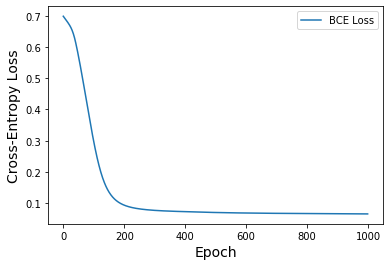

In [70]:
###### plt.title('Learning Curve', size=14)
plt.xlabel('Epoch', size=14)
plt.ylabel('Cross-Entropy Loss', size=14)
plt.plot(losses, label='BCE Loss')
plt.legend()
plt.savefig('toyModel/2DlangevinAsymmetric/lossCurve.png')

In [ ]:
# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]


In [71]:
trials = 500
batch_size = 10000

meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print("Started predictions")

committor = np.asarray([0,0])

for i in range(0,len(dataset[:,0])+1,batch_size):
    
    committorTemp = np.zeros((batch_size,2))

    xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
    yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)

    velX = np.random.normal(0, stdX, len(xarray))
    velY = np.random.normal(0, stdY, len(yarray))
    
#     factorKE = (np.square(velX) + np.square(velY))/2
    
#     velX = np.multiply(velX, factorKE)
#     velY = np.multiply(velY, factorKE)

    toPred = np.vstack((xarray,yarray,velX,velY)).T
#     toPred = scaler.transform(toPred)
    preds = model(torch.Tensor(toPred))
    preds = preds.argmax(dim=1)
    preds = np.asarray(preds.detach().numpy())
    for j in range(0, batch_size):
        
        if i+j >= len(dataset):
            committorTemp = committorTemp[:j]
            break
        predictions = preds[j*trials:(j+1)*trials]
        unique, count = np.unique(predictions, return_counts=True)
        counts = [0,0]
        if len(unique) == 1:
            counts[int(unique[0]) - 1] = count[0]
        elif len(unique) == 2:
            counts[int(unique[0]) - 1] = count[0]
            counts[int(unique[1]) - 1] = count[1]
        
        if (counts[0] + counts[1]) != 0:
            counts = np.asarray(counts)/(counts[0]+counts[1])
            
        committorTemp[j] = [counts[0],counts[1]]
        
        
        if int(i+j+1) % 10000 == 0:
            print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
    committor = np.vstack((committor,committorTemp))
    print(committor.shape, committor[-1,:])
    
committor = committor[1:]

Started predictions
Finished step 10000 of 199929
(10001, 2) [0. 1.]
Finished step 20000 of 199929
(20001, 2) [0. 1.]
Finished step 30000 of 199929
(30001, 2) [0. 1.]
Finished step 40000 of 199929
(40001, 2) [0. 1.]
Finished step 50000 of 199929
(50001, 2) [0. 1.]
Finished step 60000 of 199929
(60001, 2) [1. 0.]
Finished step 70000 of 199929
(70001, 2) [1. 0.]
Finished step 80000 of 199929
(80001, 2) [0. 1.]
Finished step 90000 of 199929
(90001, 2) [0. 1.]
Finished step 100000 of 199929
(100001, 2) [0. 1.]
Finished step 110000 of 199929
(110001, 2) [0. 1.]
Finished step 120000 of 199929
(120001, 2) [0. 1.]
Finished step 130000 of 199929
(130001, 2) [1. 0.]
Finished step 140000 of 199929
(140001, 2) [1. 0.]
Finished step 150000 of 199929
(150001, 2) [1. 0.]
Finished step 160000 of 199929
(160001, 2) [1. 0.]
Finished step 170000 of 199929
(170001, 2) [1. 0.]
Finished step 180000 of 199929
(180001, 2) [1. 0.]
Finished step 190000 of 199929
(190001, 2) [0. 1.]
(199930, 2) [0. 1.]


In [39]:
# trials = 500
# batch_size = 10000

# meanX,stdX=norm.fit(velocities[:,0])
# meanY,stdY=norm.fit(velocities[:,1])

# print("Started predictions")

# committor = np.asarray([0,0,0])

# for i in range(0,len(dataset[:,0])+1,batch_size):
    
#     committorTemp = np.zeros((batch_size,3))

#     xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
#     yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)

#     velX = np.random.normal(meanX, stdX, len(xarray))
#     velY = np.random.normal(meanY, stdY, len(yarray))

#     toPred = np.vstack((xarray,yarray,velX,velY)).T
#     toPred = scaler.transform(toPred)
#     preds = clf.predict(toPred)    

#     for j in range(0, batch_size):
        
#         if i+j >= len(dataset):
#             committorTemp = committorTemp[:j]
#             break
#         predictions = preds[j*trials:(j+1)*trials]
#         unique, count = np.unique(predictions, return_counts=True)
#         if len(unique) == 1:        
#             if unique == 1:
#                 counts = [count[0], 0]

#             else:
#                 counts = [0, count[0]]
#         else:

#             counts = count

#         counts = np.asarray(counts)/trials
#         committorTemp[j] = [dataset[i+j][0],dataset[i+j][1],counts[1]]
        
        
#         if int(i+j+1) % 10000 == 0:
#             print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
#     committor = np.vstack((committor,committorTemp))
#     print(committor.shape)
    
# committor = committor[1:]

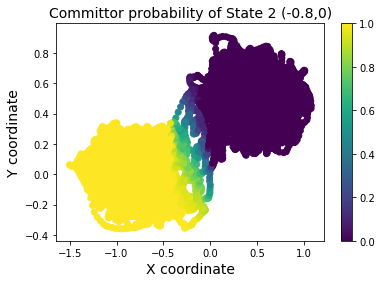

In [83]:
import matplotlib.tri as tri

x = dataset[:,0]
y = dataset[:,1]
z = committor[:,0]

plt.title("Committor probability of State 2 (-0.8,0)", size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(x,y,c=z)
plt.colorbar()
plt.savefig("toyModel/2DlangevinAsymmetric/MLP_CommProb.png")

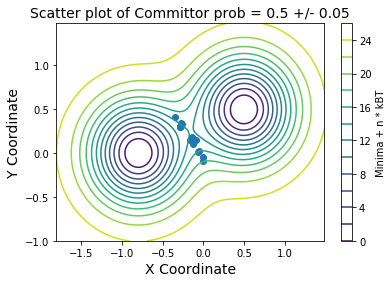

In [76]:
deviation = 0.05

transitionPtsIndices = np.where(np.logical_and(committor[:,1] > (0.5 - deviation), \
                         committor[:,1] < (0.5 + deviation)))

transitionPts = dataset[transitionPtsIndices]

minPotential = potential[:,2].min()

transitionPts = np.asarray(transitionPts)
plt.title("Scatter plot of Committor prob = 0.5 +/- " + str(deviation), size=14)
plt.xlabel("X Coordinate", size=14)
plt.ylabel("Y Coordinate", size=14)
plt.scatter(transitionPts[:,0],transitionPts[:,1])
plt.tricontour(potential[:,0],potential[:,1],(potential[:,2] - minPotential)/my_kBT, 15)
plt.colorbar(label='Minima + n * kBT')
plt.savefig("toyModel/2DlangevinAsymmetric/MLP_TS.png")

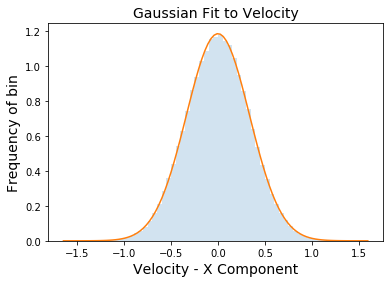

<Figure size 432x288 with 0 Axes>

In [15]:
meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

bins_list = np.arange(-1.5,1.5,0.05)

plt.hist(velocities[:,0], density=True, bins=bins_list, histtype='stepfilled', alpha=0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, meanX, stdX)

plt.title("Gaussian Fit to Velocity", size=14)
plt.xlabel("Velocity - X Component", size=14)
plt.ylabel("Frequency of bin", size=14)
plt.plot(x, y)
plt.show()
plt.savefig("toyModel/2DlangevinAsymmetric/gaussianFit.png")

In [18]:
print(meanX, meanY)
print(stdX, stdY)

0.00016290561996814607 0.00042038325078804173
0.33657410346927547 0.3272636454365257


In [78]:
print(euclidean([-0.5,-0.5],[0.5,0.5]))
print(euclidean([-0.8,0],[0.5,0.5]))

1.4142135623730951
1.392838827718412


In [82]:
print(twoDpotential(0,0) - twoDpotential(x1,y1))
print(twoDpotential(0,0) - twoDpotential(x2,y2))

1.3147606785730541
1.3147375891730542
